In [1]:
import numpy as np
import mlgrad.models as models
import mlgrad.loss as loss
import mlgrad.funcs as funcs
import mlgrad.avragg as avragg
import mlgrad.gd as gd
import mlgrad.funcs2 as funcs2
import mlgrad.weights as weights
from mlgrad.utils import exclude_outliers, get_outliers

from mlgrad import averager_it, averager_fg, fg, erm_fg, sg, erm_sg, irgd, erm_irgd, erisk, mrisk

#import sklearn.linear_model as sklm

import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use(['seaborn-notebook', 'seaborn-ticks'])

import sys
print(sys.version)

3.13.3 (main, Apr 10 2025, 21:38:51) [GCC 14.2.0]


In [2]:
df = pd.read_csv("data/starsCYG.csv", sep=',', usecols=["log.Te", "log.light"], )
print(len(df))

47


In [3]:
Y = df["log.light"].values
X = df["log.Te"].values

X -= X.mean()
Y -= Y.mean()
# x_min, x_max = X.min(), X.max()
# X = (X - x_min) / (x_max - x_min)
# y_min, y_max = Y.min(), Y.max()
# Y = (Y - y_min) / (y_max - y_min)

Xs = X.reshape((-1,1))

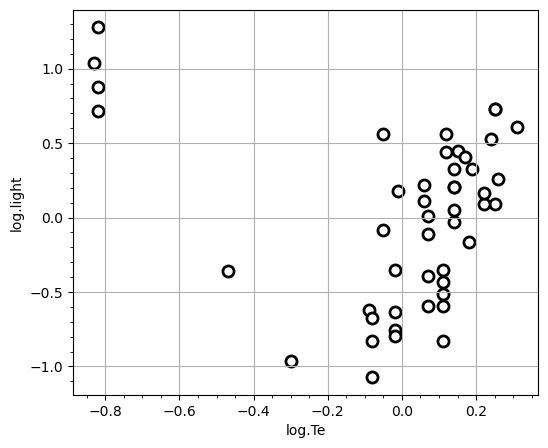

In [4]:
plt.figure(figsize=(6.0, 5.0))
plt.scatter(X, Y, s=64, c='w', edgecolors='k', linewidths=2.)
plt.minorticks_on()
plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
# plt.xlim(-0.9, 0.6)
# plt.ylim(-2.5, 2.0)
plt.show()

In [5]:
loss_func_sq = loss.ErrorLoss(funcs.Square())
loss_func_rsq = loss.RelativeErrorLoss(funcs.Square())
loss_func_abs = loss.ErrorLoss(funcs.Absolute())

In [6]:
mod1 = models.LinearModel(1)
mod1.init_param()

print(np.array(mod1.param))

[-0.443 -0.262]


K=1019 param=[-4.753e-05 -4.133e-01]


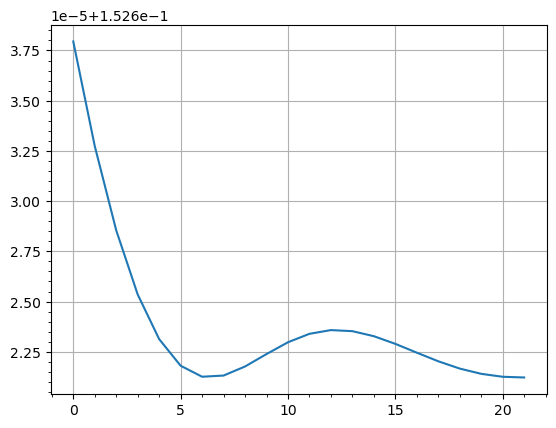

In [7]:
er1 = erisk(Xs, Y, mod1, loss_func_sq)
alg_fg1 = erm_fg(er1, h=0.001, tol=1.0e-8, verbose=1, n_restart=5)

plt.plot(alg_fg1.lvals)
plt.minorticks_on()
plt.grid(1)
plt.show()

In [33]:
mod2 = models.LinearModel(1)
mod2.init_param()

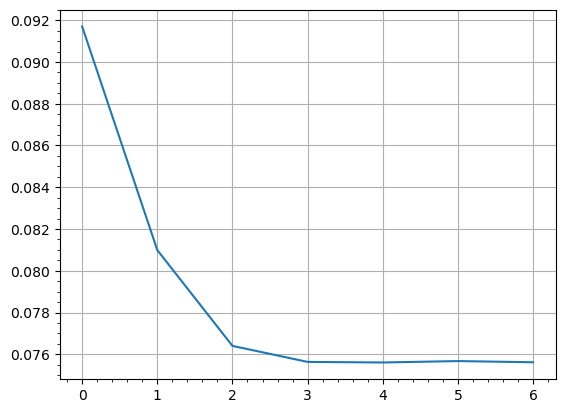

In [34]:
er2 = erisk(Xs, Y, mod2, loss_func_sq)
alg_fg2 = fg(er2, h=0.001, tol=1.0e-8)
avg2 = avragg.MAverage(funcs.Quantile_Sqrt(0.85, 0.001))
avg2 = avragg.WMAverage(avg2)
wg2 = weights.MWeights(avg2, er2)
irgd2 = erm_irgd(alg_fg2, wg2, n_iter=21, tol=1.0e-5)

plt.plot(irgd2.lvals)
plt.minorticks_on()
plt.grid(1)
plt.show()

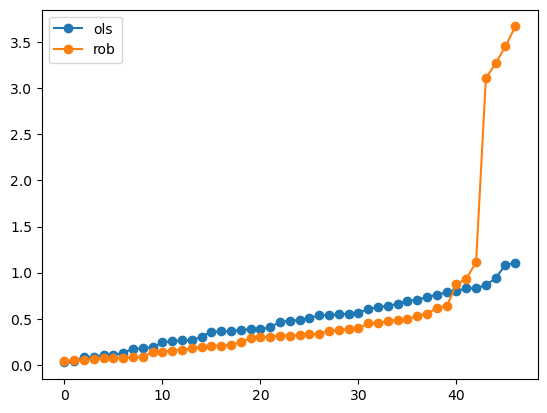

In [35]:
res1 = np.abs(Y - mod1.evaluate_all(Xs))
res1.sort()
res2 = np.abs(Y - mod2.evaluate_all(Xs))
res2.sort()
#ranges = np.arange(len(res1))

plt.plot(res1, marker='o', label='ols')
plt.plot(res2, marker='o', label='rob')
plt.legend()
plt.show()

In [36]:
Err = np.abs(Y - mod2.evaluate_all(Xs))

X1, Y1 = exclude_outliers(mod2, Xs, Y, 7) 
X1_, Y1_ = get_outliers(mod2, Xs, Y, 7) 
X1s = X1.reshape(-1,1)

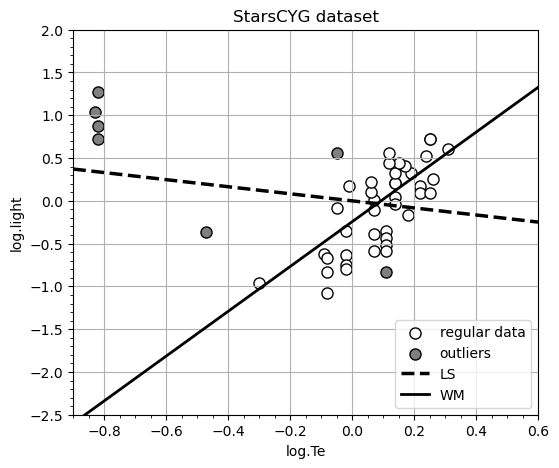

In [37]:
plt.figure(figsize=(6.0, 5.0))
plt.title('StarsCYG dataset')
plt.scatter(X1, Y1, s=64, c='w', edgecolors='k', linewidths=1., label='regular data')
plt.scatter(X1_, Y1_, s=64, c='Grey', edgecolors='k', linewidths=1., label='outliers')
X0 = np.linspace(-0.9, 0.6, 20)
plt.plot(X0, mod1.evaluate_all(X0.reshape(-1,1)), c='k', linestyle='--', linewidth=2.5, label=r'LS')
plt.plot(X0, mod2.evaluate_all(X0.reshape(-1,1)), color='k', linewidth=2., label=r'WM')
plt.minorticks_on()
plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.xlim(-0.9, 0.6)
plt.ylim(-2.5, 2.0)
plt.legend(loc='best')
plt.show()

In [13]:
mod21 = models.LinearModel(1)
mod21.init_param()

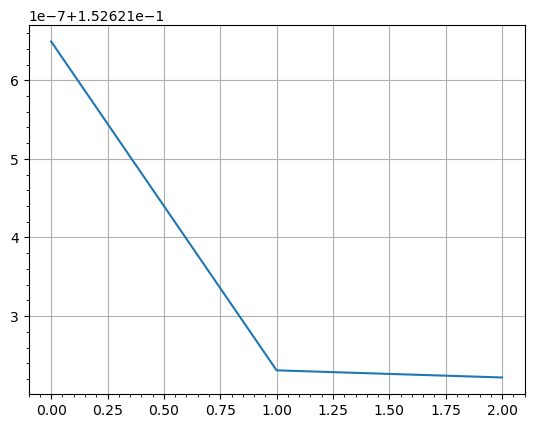

In [14]:
er21 = erisk(Xs, Y, mod21, loss_func_sq)
alg_fg21 = fg(er21, h=0.001, tol=1.0e-8)
wg21 = weights.RWeights(er21)
irgd21 = erm_irgd(alg_fg21, wg21, n_iter=21, tol=1.0e-8, n_restart=2)

plt.plot(irgd21.lvals)
plt.minorticks_on()
plt.grid(1)
plt.show()

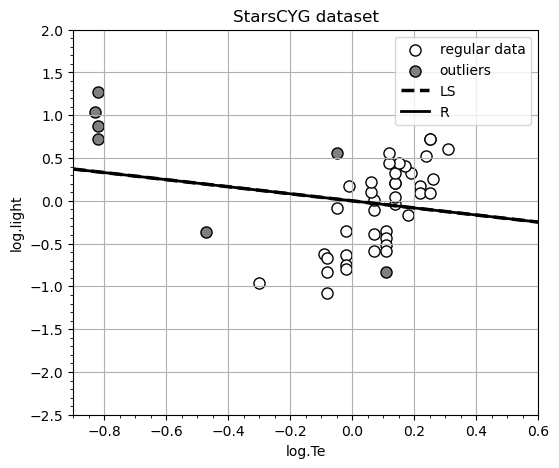

In [15]:
plt.figure(figsize=(6.0, 5.0))
plt.title('StarsCYG dataset')
plt.scatter(X1, Y1, s=64, c='w', edgecolors='k', linewidths=1., label='regular data')
plt.scatter(X1_, Y1_, s=64, c='Grey', edgecolors='k', linewidths=1., label='outliers')
X0 = np.linspace(-0.9, 0.6, 20)
plt.plot(X0, mod1.evaluate_all(X0.reshape(-1,1)), c='k', linestyle='--', linewidth=2.5, label=r'LS')
plt.plot(X0, mod21.evaluate_all(X0.reshape(-1,1)), color='k', linewidth=2., label=r'R')
plt.minorticks_on()
plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.xlim(-0.9, 0.6)
plt.ylim(-2.5, 2.0)
plt.legend(loc='best')
plt.show()

In [26]:
mod22 = models.LinearModel(1)
mod22.init_param()

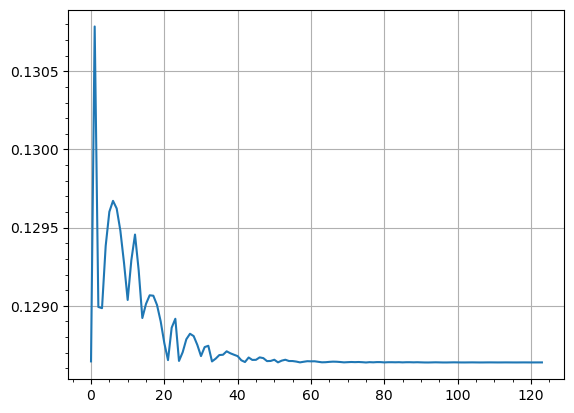

In [30]:
avg22 = avragg.MAverage(funcs.Quantile_Sqrt(0.85, 0.001))
avg22 = avragg.WMAverage(avg22)
mr2 = mrisk(Xs, Y, mod22, loss_func_sq, avg22)
alg_fg2 = fg(mr2, h=0.01, tol=1.0e-8)
alg_fg2.fit()

plt.plot(alg_fg2.lvals)
plt.minorticks_on()
plt.grid(1)
plt.show()

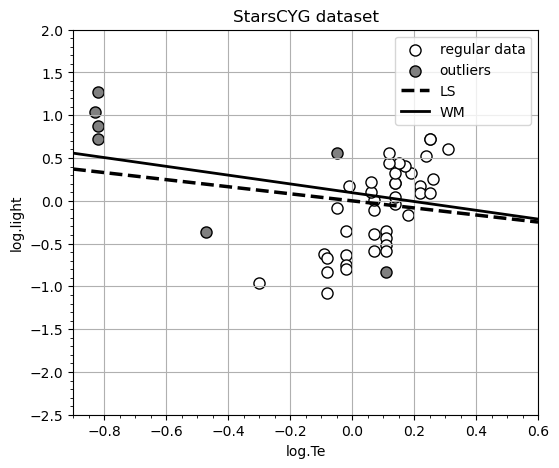

In [32]:
plt.figure(figsize=(6.0, 5.0))
plt.title('StarsCYG dataset')
plt.scatter(X1, Y1, s=64, c='w', edgecolors='k', linewidths=1., label='regular data')
plt.scatter(X1_, Y1_, s=64, c='Grey', edgecolors='k', linewidths=1., label='outliers')
X0 = np.linspace(-0.9, 0.6, 20)
plt.plot(X0, mod1.evaluate(X0.reshape(-1,1)), c='k', linestyle='--', linewidth=2.5, label=r'LS')
plt.plot(X0, mod22.evaluate(X0.reshape(-1,1)), color='k', linewidth=2., label=r'WM')
plt.minorticks_on()
plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.xlim(-0.9, 0.6)
plt.ylim(-2.5, 2.0)
plt.legend(loc='best')
plt.show()

In [19]:
mod3 = models.LinearModel(1)
mod3.init_param()

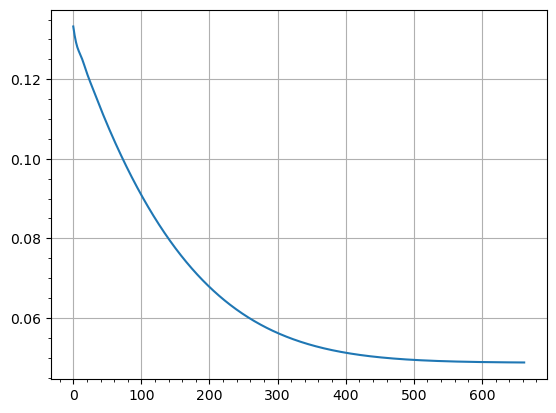

In [20]:
er3 = erisk(X1s, Y1, mod3, loss_func_sq)
alg_fg3 = erm_fg(er3, h=0.01, tol=1.0e-6, verbose=0)

plt.plot(alg_fg3.lvals)
plt.minorticks_on()
plt.grid(1)
plt.show()

In [21]:
40/47

0.851063829787234